# check oof df

In [1]:
import os
import gc
import yaml
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/kaggle/src/dss_utils")
sys.path.append("/kaggle/src/exp")
sys.path.append("/kaggle/src/model")
sys.path.append("/kaggle/src/data")
from dss_metrics import score
from training_loop import get_valid_values_dict, concat_valid_input_info, get_oof_df, get_key_df
from dss_model import get_model
from dss_dataloader import get_loader


In [2]:
output_dir = "/kaggle/working"
exp_name = "exp012_targetdownsample_epoch10"

folds = [0, 1, 2, 3, 4]
oof_df = pd.DataFrame()
for i in folds:
    print("fold", i)
    df = pd.read_parquet(os.path.join(output_dir, "_oof", exp_name, f"raw_oof_df_fold{i}.parquet"))
    oof_df = pd.concat([oof_df, df], axis=0)


fold 0
fold 1
fold 2
fold 3
fold 4


In [3]:
oof_df = oof_df.sort_values(["series_id", "step"])
display(oof_df)


,series_id,step,minute,second,class_pred,class_target
0,038441c925bb,3240.0,0,0,0.008696,0.0
1,038441c925bb,3241.0,0,5,-1.000000,-1.0
2,038441c925bb,3242.0,0,10,-1.000000,-1.0
3,038441c925bb,3243.0,0,15,-1.000000,-1.0
4,038441c925bb,3244.0,0,20,-1.000000,-1.0
...,...,...,...,...,...,...
16555675,fe90110788d2,589315.0,59,35,-1.000000,-1.0
16555676,fe90110788d2,589316.0,59,40,-1.000000,-1.0
16555677,fe90110788d2,589317.0,59,45,-1.000000,-1.0
16555678,fe90110788d2,589318.0,59,50,-1.000000,-1.0


In [4]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn


# 1step 0.5secで30minなら60*30=1800step
def postprocess_downsample_fn(df, N=3, maxpool_kernel_size=3, maxpool_stride=1):
    df = df.copy()
    df = df[df["second"]==0].reset_index(drop=True)
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    not_predicted_mask = (df["class_pred"] != -1).astype(int)
    df["event_pred"] = df["event_pred"] * not_predicted_mask

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def postprocess_downsample_notmaxpool(df, N=11):
    df = df.copy()
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def make_submission_df(df, threshold=0.1):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


In [5]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["step"].notnull()].copy()
# train_event_df = train_event_df[train_event_df["series_id"].isin(oof_df["series_id"].unique())].copy()
train_event_df = train_event_df.reset_index(drop=True)
display(train_event_df.head())


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [6]:
oof_df = postprocess_downsample_fn(oof_df, N=9, maxpool_kernel_size=3, maxpool_stride=1)
sub_df = make_submission_df(oof_df, threshold=0.01)


In [7]:
series_id_list =[]
score_list = []
detected_event_num_list = []
for series_id in train_event_df["series_id"].unique():
    scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
    scoring_sub_df = sub_df[sub_df["series_id"] == series_id].copy()
    if len(scoring_sub_df) == 0 or len(scoring_event_df) == 0:
        series_id_list.append(series_id)
        series_score = 0
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score, len(scoring_sub_df), len(scoring_event_df))
    else:
        series_score = score(scoring_event_df, scoring_sub_df)
        series_id_list.append(series_id)
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score)


038441c925bb 0.7035839366757506
03d92c9f6f8a 0.716671626984127
0402a003dae9 0.6530904015315311
04f547b8017d 0.8404515353285891
05e1944c3818 0.8708639971139969
062cae666e2a 0.8041666666666665
062dbd4c95e6 0.6479745030449917
08db4255286f 0.8011568930233238
0a96f4993bd7 0.5857498188544077
0cd1e3d0ed95 0.839484126984127
0ce74d6d2106 0.8516289459128428
0cfc06c129cc 0.8049014524421161
0d0ad1e77851 0.8454024213830148
0dee4fda51c3 0.6975115149361546
0ec9fc461819 0.8546059973289555
0ef7d94fde99 0.7753841683982765
0f572d690310 0.7513996282967584
10469f6765bf 0.4658994708994709
1087d7b0ff2e 0.6798693916323468
10f8bc1f7b07 0.8610037584404562
12d01911d509 0.7020488089692443
1319a1935f48 0.7933154881153133
137771d19ca2 0.8187500000000001
137b99e936ab 0.6475176816939427
13b4d6a01d27 0.7083333333333333
148471991ffb 0.35197434096173735
154fe824ed87 0.7734036542000355
16fe2798ed0f 0.6915204300049982
1716cd4163b2 0.7504117581174652
1762ab70ec76 0.6318336277996233
188d4b7cd28b 0.7880234169122802
18a0ca034

In [8]:
score_df = pd.DataFrame({
    "series_id": series_id_list,
    "score": score_list,
    "detected_event_num": detected_event_num_list
})
score_df.to_csv(os.path.join(output_dir, exp_name, "score_df.csv"), index=False)


,series_id,score,detected_event_num
0,aed3850f65f0,1.000000,4
1,c5365a55ebb7,0.950000,17
2,653622ac8363,0.921398,263


<Axes: >

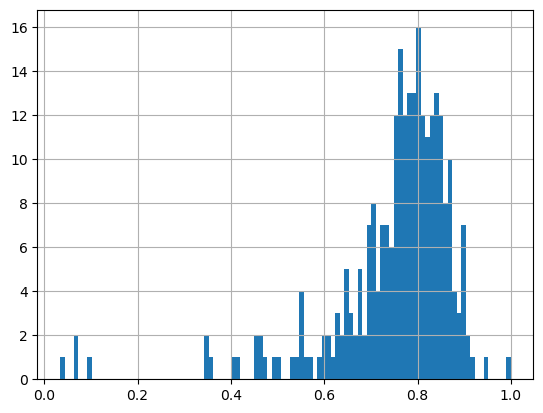

In [9]:
score_df = score_df.sort_values("score", ascending=False).reset_index(drop=True)
display(score_df.head(3))
score_df["score"].hist(bins=100)


In [12]:
score_df = score_df.sort_values("score", ascending=True).reset_index(drop=True)
display(score_df.head(10))
bad_detect_series_id_list = score_df[score_df["score"] < 0.5]["series_id"].values.tolist()


,series_id,score,detected_event_num
0,60d31b0bec3b,0.033568,336
1,f56824b503a0,0.069454,89
2,e4500e7e19e1,0.070518,50
3,4feda0596965,0.099848,99
4,60e51cad2ffb,0.351944,33
5,148471991ffb,0.351974,272
6,b7fc34995d0f,0.361111,16
7,db5e0ee1c0ab,0.402609,349
8,44a41bba1ee7,0.412372,244
9,d5be621fd9aa,0.453388,60


In [13]:
oof_df


,series_id,step,minute,second,class_pred,class_target,event_pred
0,038441c925bb,3240.0,0,0,0.008696,0.0,0.005988
1,038441c925bb,3252.0,1,0,0.003792,0.0,0.000000
2,038441c925bb,3264.0,2,0,0.002439,0.0,0.000000
3,038441c925bb,3276.0,3,0,0.001729,0.0,0.000000
4,038441c925bb,3288.0,4,0,0.001750,0.0,0.000000
...,...,...,...,...,...,...,...
6896815,fe90110788d2,589260.0,55,0,0.002079,-1.0,-0.000000
6896816,fe90110788d2,589272.0,56,0,0.002188,-1.0,-0.000000
6896817,fe90110788d2,589284.0,57,0,0.001987,-1.0,-0.000000
6896818,fe90110788d2,589296.0,58,0,0.002578,-1.0,-0.000000


In [14]:
orig_df = pd.read_parquet("/kaggle/input/targetdownsample_train_series_fold.parquet")


In [28]:
orig_df["series_date_key"]


0              1
1              1
2              1
3              1
4              1
            ... 
82761835    7744
82761836    7744
82761837    7744
82761838    7744
82761839    7744
Name: series_date_key, Length: 82761840, dtype: int64

60d31b0bec3b
12


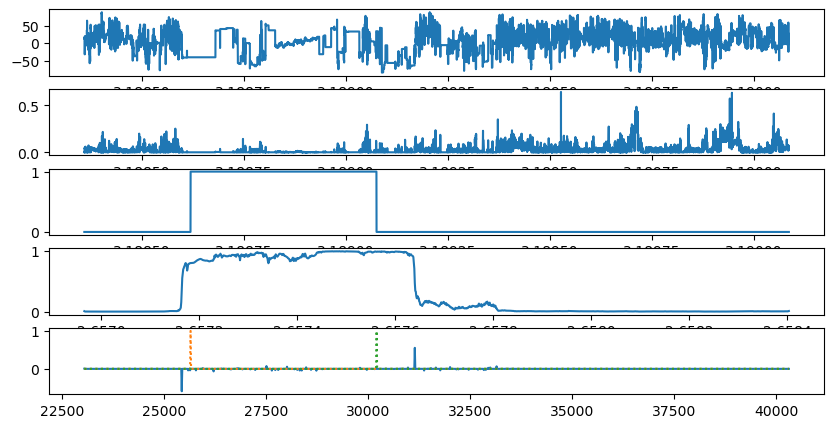

f56824b503a0
12


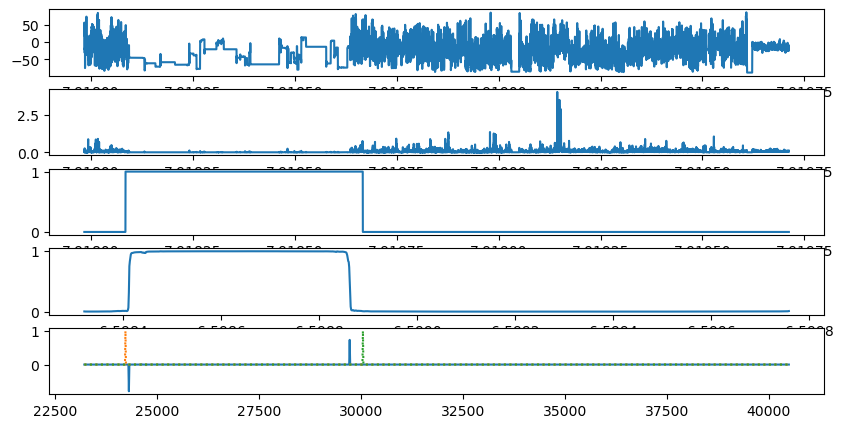

e4500e7e19e1
3


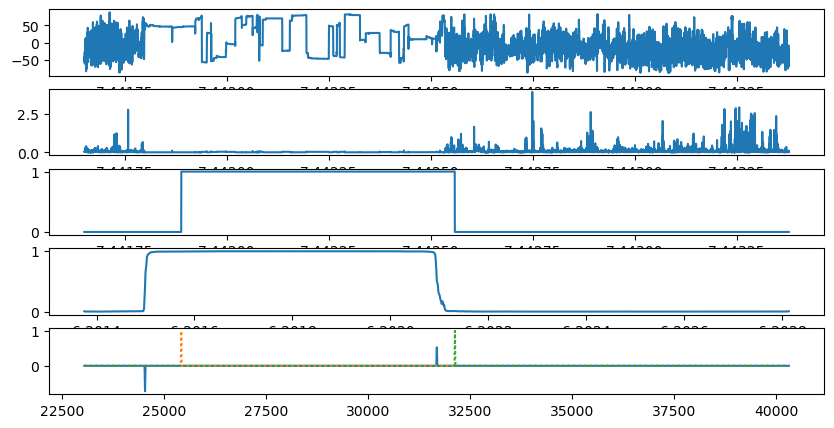

4feda0596965
15


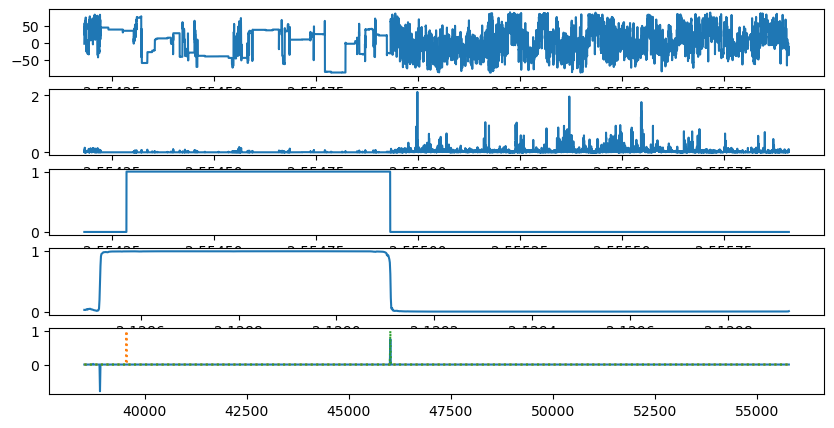

In [32]:
display_col = ["series_id", "series_date_key", "date","fold", "step"]
for idx, series_id in enumerate(bad_detect_series_id_list):
    if idx > 3:
        break
    print(series_id)
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    key_unique = input_df["series_date_key"].unique()
    print(len(key_unique))
    for key in key_unique:
        input_key_df = input_df[input_df["series_date_key"] == key]
        start_step = input_key_df["step"].min()
        end_step = input_key_df["step"].max()
        pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
        plt.figure(figsize=(10, 5))
        plt.subplot(5, 1, 1)
        plt.plot(input_key_df["anglez"])
        plt.subplot(5, 1, 2)
        plt.plot(input_key_df["enmo"])
        plt.subplot(5, 1, 3)
        plt.plot(input_key_df["event"])
        plt.subplot(5, 1, 4)
        plt.plot(pred_key_df["class_pred"])
        plt.subplot(5, 1, 5)
        plt.plot(pred_key_df["step"], pred_key_df["event_pred"])
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_onset"].values, ":")
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_wakeup"].values, ":")
        plt.show()
        break


In [33]:
mid_detect_series_id_list = score_df[(score_df["score"] > 0.3) & (score_df["score"] < 0.6)]["series_id"].values.tolist()


60e51cad2ffb
3


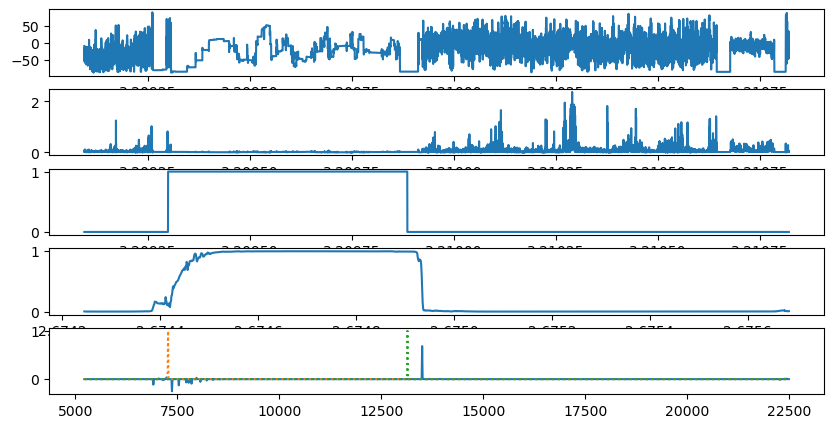

148471991ffb
16


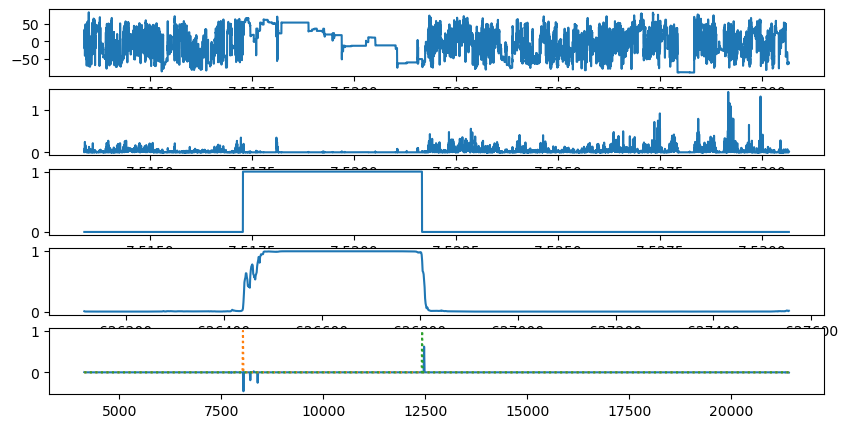

b7fc34995d0f
3


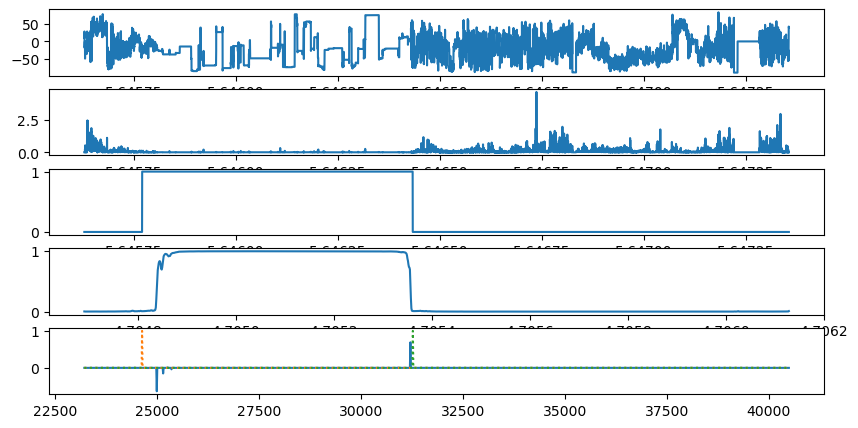

db5e0ee1c0ab
21


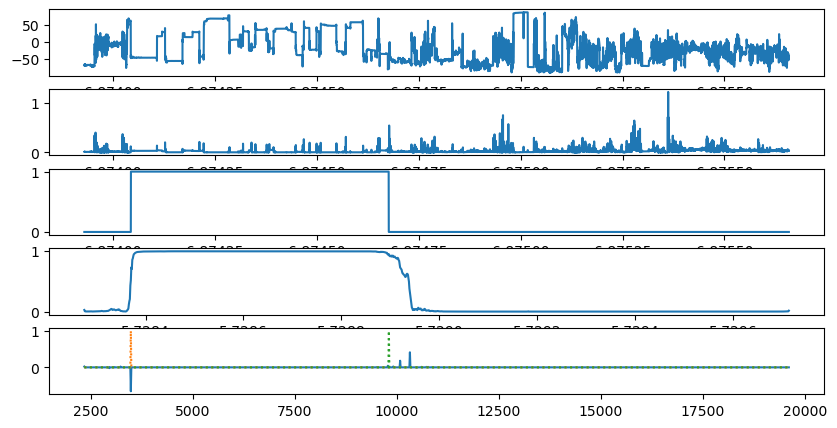

In [35]:
display_col = ["series_id", "series_date_key", "date","fold", "step"]
for idx, series_id in enumerate(mid_detect_series_id_list):
    if idx > 3:
        break
    print(series_id)
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    key_unique = input_df["series_date_key"].unique()
    print(len(key_unique))
    for key in key_unique:
        input_key_df = input_df[input_df["series_date_key"] == key]
        start_step = input_key_df["step"].min()
        end_step = input_key_df["step"].max()
        pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
        plt.figure(figsize=(10, 5))
        plt.subplot(5, 1, 1)
        plt.plot(input_key_df["anglez"])
        plt.subplot(5, 1, 2)
        plt.plot(input_key_df["enmo"])
        plt.subplot(5, 1, 3)
        plt.plot(input_key_df["event"])
        plt.subplot(5, 1, 4)
        plt.plot(pred_key_df["class_pred"])
        plt.subplot(5, 1, 5)
        plt.plot(pred_key_df["step"], pred_key_df["event_pred"])
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_onset"].values, ":")
        plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_wakeup"].values, ":")
        plt.show()
        break
